## Packages and Presets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
import torch
from skimpy import clean_columns
from sklearn.model_selection import train_test_split
from pickle import load
import shap
import tensorflow

import sys
sys.path.append("../..")
from utils.utils import set_all_seeds

%load_ext blackcellmagic

In [2]:
SEED = 123
GRID_SIZE = 10_000

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading Data and Model

In [3]:
train_df = pd.read_csv("../data/heart_failure/train_val_split.csv").pipe(
    clean_columns
)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
outlier_idx = X_train.query("resting_bp == 0").index
print(f"{outlier_idx=}")
X_train = X_train.drop(outlier_idx)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)


outlier_idx=Index([366], dtype='int64')


In [17]:
X_train.shape

(733, 12)

We also have to load the test (X) data as they will be used later for the SHAP values:

In [24]:
test_df = pd.read_csv("../data/heart_failure/test_split.csv").pipe(clean_columns)
X_test = test_df.drop(columns=["heart_disease"], axis=1)
# create categorical variable for cholesterol
X_test["chol_level"] = pd.cut(
    X_test["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)
y_test=test_df['heart_disease']
y_test = y_test[X_test.index]


preprocessor = load(open("../models/preprocessor.pkl", "rb"))
#model = torch.load("../models/mlp.pth", map_location=torch.device('cpu'))
model = torch.load("../models/mlp.pth")

In [6]:
# preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [7]:
# set all seeds for reproducibility
set_all_seeds(SEED)
# set model to eval mode to disable dropout
model.eval()

MLP(
  (nn): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

## SHAP Values

Before we start off with the SHAP values, we'll have to create a vector of clean column names:

In [8]:
names_cleaned = [
    "Age",
    "Resting Blood Pressure",
    "Cholesterol",
    "Maximum Heart Rate",
    "Old Peak",
    "Sex Female",
    "Sex Male",
    "Chest Pain: Type Asymptomatic",
    "Chest Pain: Type Atypical Angina",
    "Chest Pain: Type Non-Anginal Pain",
    "Chest Pain: Type Typical Angina",
    "Fasting Blood Sugar < 120 mg/dl",
    "Fasting Blood Sugar > 120 mg/dl",
    "Resting ECG: Left Ventricular Hypertrophy",
    "Resting ECG: Normal",
    "Resting ECG: ST-T Wave Abnormality",
    "Exercise-Induced Angina: No",
    "Exercise-Induced Angina: Yes",
    "ST Slope: Downsloping",
    "ST Slope: Flat",
    "ST Slope: Upsloping",
    "Cholesterol Level: Borderline",
    "Cholesterol Level: High",
    "Cholesterol Level: Imputed",
    "Cholesterol Level: Normal"    
]

Since our model returns two outputs but the DeepExplainer only expects one, we will first have to write a class that only returns the first output of the model (and reshape it). We will then use this class to calculate the SHAP values:

In [9]:
class MLP_Summed_Logits(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # have to add a dimension since explainer did not work otherwise
        #print(self.model(x)[0].shape)
        return self.model(x).unsqueeze(-1)
    
#self.model(x).unsqueeze(-1)

In [80]:
model_summed_logits = MLP_Summed_Logits(model)

train_x = torch.tensor(X_train_preprocessed).float().to(DEVICE)
test_x = torch.tensor(X_test_preprocessed).float().to(DEVICE)

explainer = shap.DeepExplainer(
    model_summed_logits, train_x
)

shap_values = explainer.shap_values(test_x)

In [15]:
print(f"{shap_values.shape=}")

shap_values.shape=(184, 25, 1)


Note that the SHAP values for some reason have a third dimension. Thus, we will have to reshape the shap_values array to avoid errors in the plotting function.

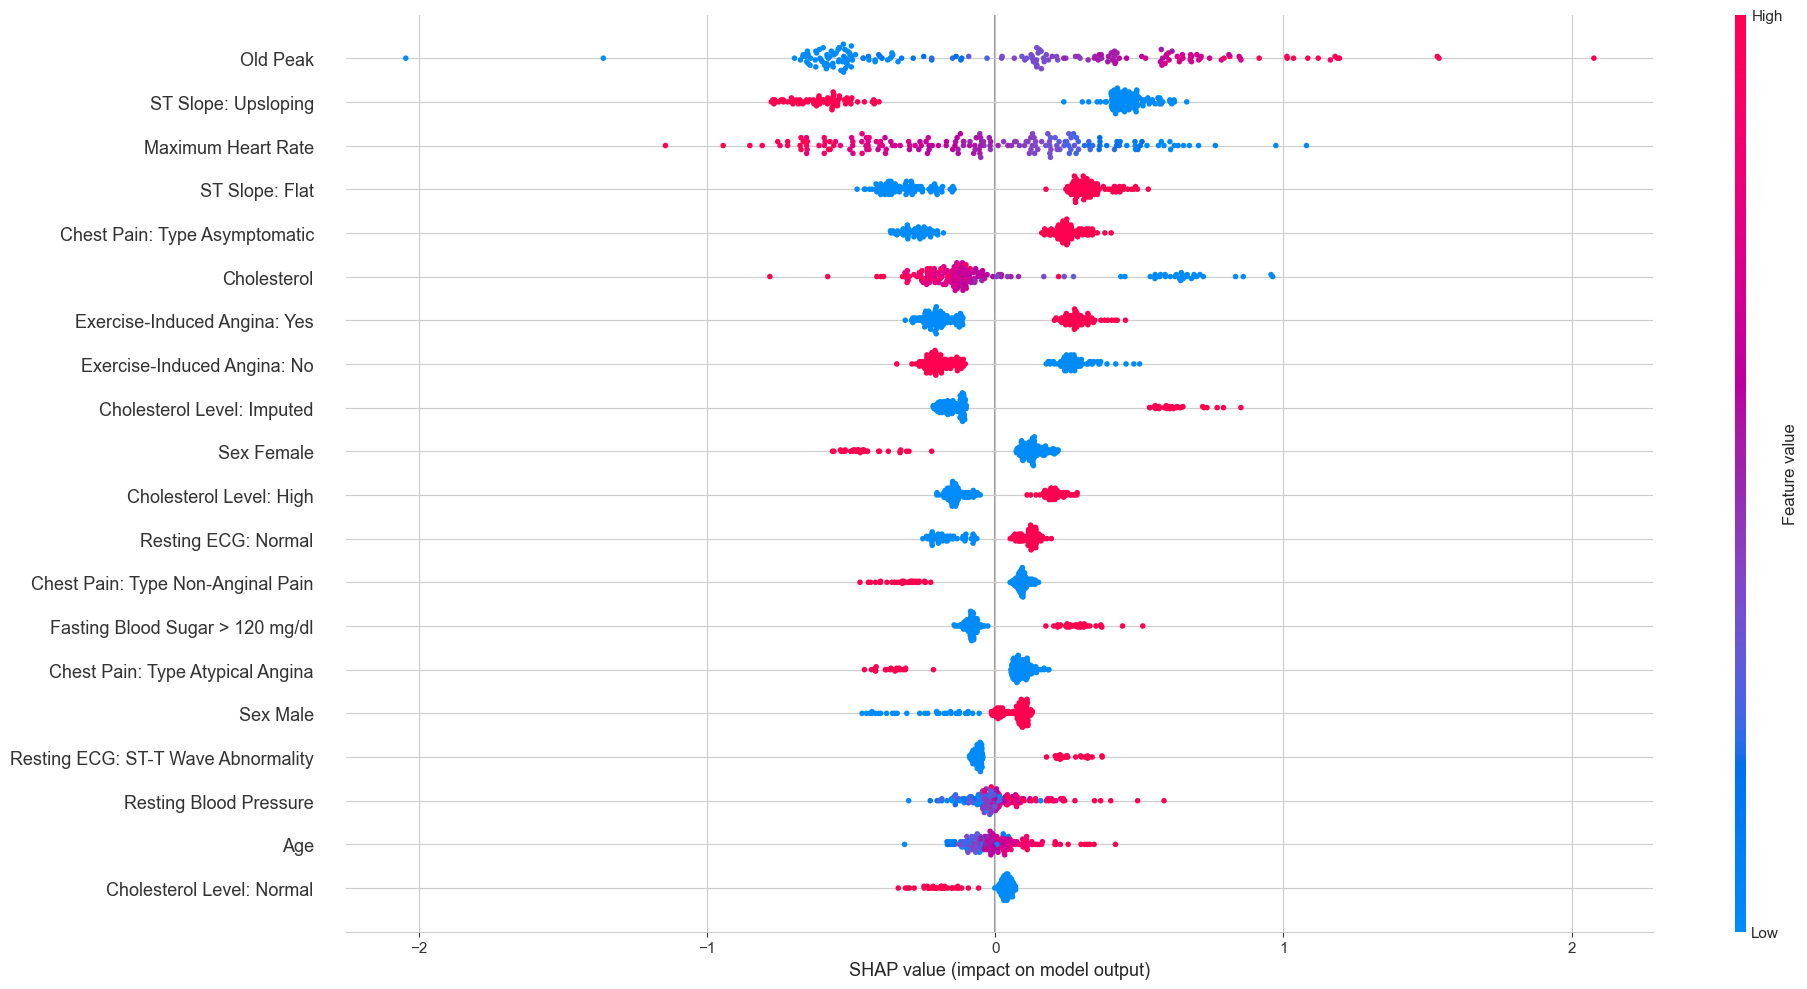

In [81]:
# create dataframe for plotting
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=names_cleaned)

shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="dot",
    plot_size=[20, 10],
)

A useful guide to interpreting these outputs can be found here: 
https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/

Since the variables are sorted by their importance, we can see that Oldpeak is the most influential. It seems like the Oldpeak values mainly negatively impacted the SHAP values, i.e. had a negative contribution.

<span style="color:red"> Then, visualize SHAP explanations of the outputs of two positive and negative samples and feature importances of the overall model (2 Pt)

In [71]:
ind0=y_test[y_test==0][0:2]
ind1=y_test[y_test==1][0:2]

#Have to convert them to arrays, since PyTorch can't handle it otherwise
X0_array=X_test_preprocessed_df.iloc[[6,10]].values
X1_array=X_test_preprocessed_df.iloc[[0,1]].values

In [72]:
# Convert numpy array to PyTorch tensor
test_x0 = torch.tensor(X0_array).float().to(DEVICE)
test_x1 = torch.tensor(X1_array).float().to(DEVICE)

# Extract column names from DataFrame
feature_names = X0.columns.tolist()

#explainer = shap.DeepExplainer(model_summed_logits, train_x)
shap_values0 = explainer.shap_values(test_x0)
shap_values1 = explainer.shap_values(test_x1)

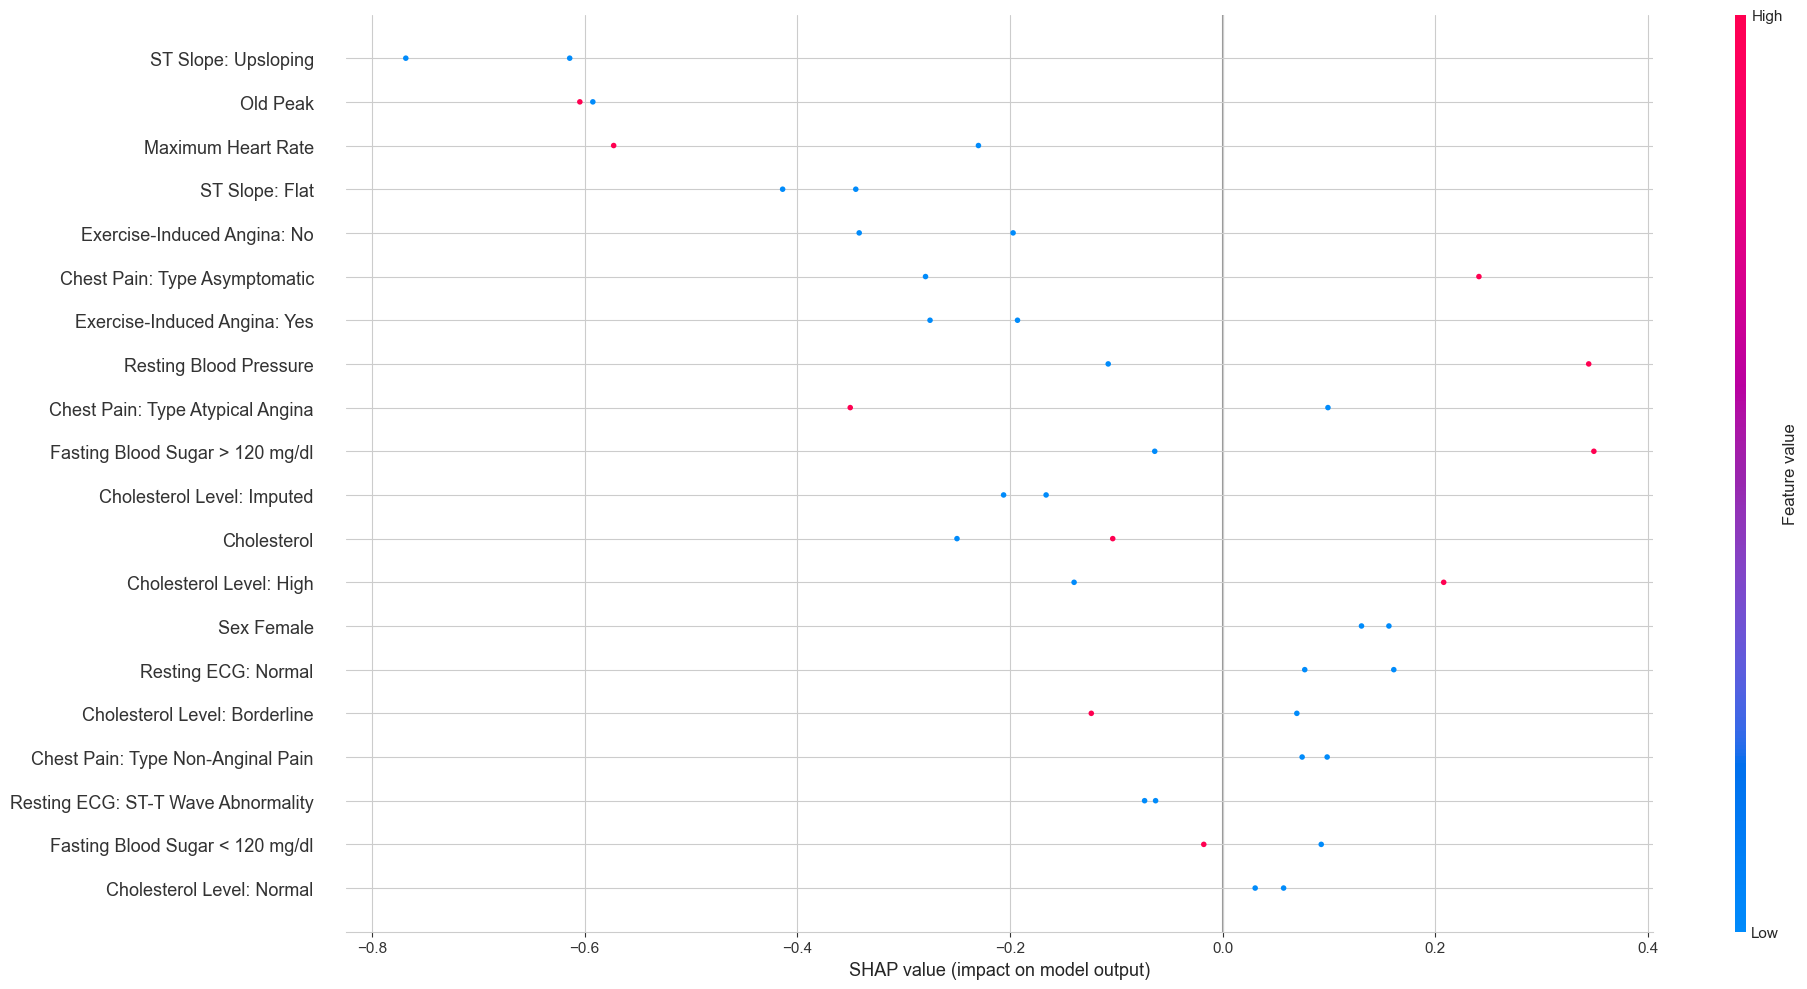

In [78]:
# Pass feature names to summary_plot
shap.summary_plot(
    shap_values0.reshape(-1, X0_array.shape[1]),
    X0_array,
    feature_names=feature_names,
    plot_type="dot",
    plot_size=[20, 10],
)

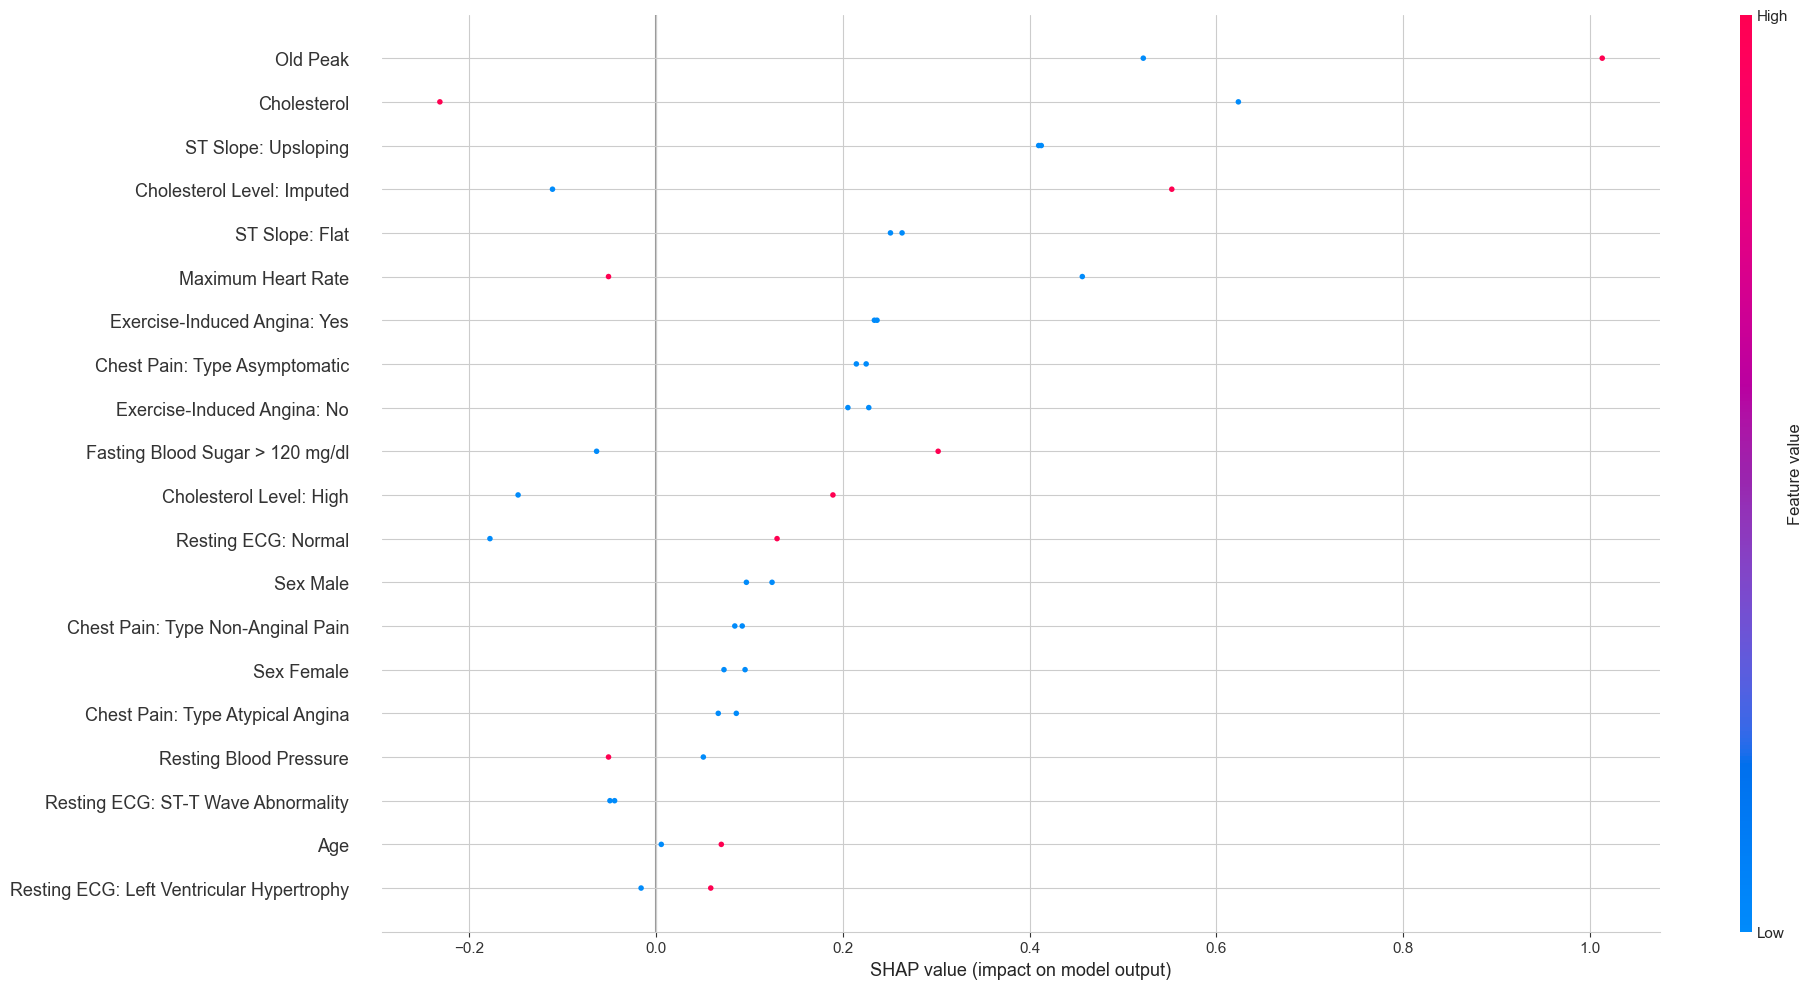

In [77]:
# Pass feature names to summary_plot
shap.summary_plot(
    shap_values1.reshape(-1, X1_array.shape[1]),
    X1_array,
    feature_names=feature_names,
    plot_type="dot",
    plot_size=[20, 10],
)

<span style="color:red"> Are feature importances consistent across different
predictions and compared to overall importance values (1 Pt)?

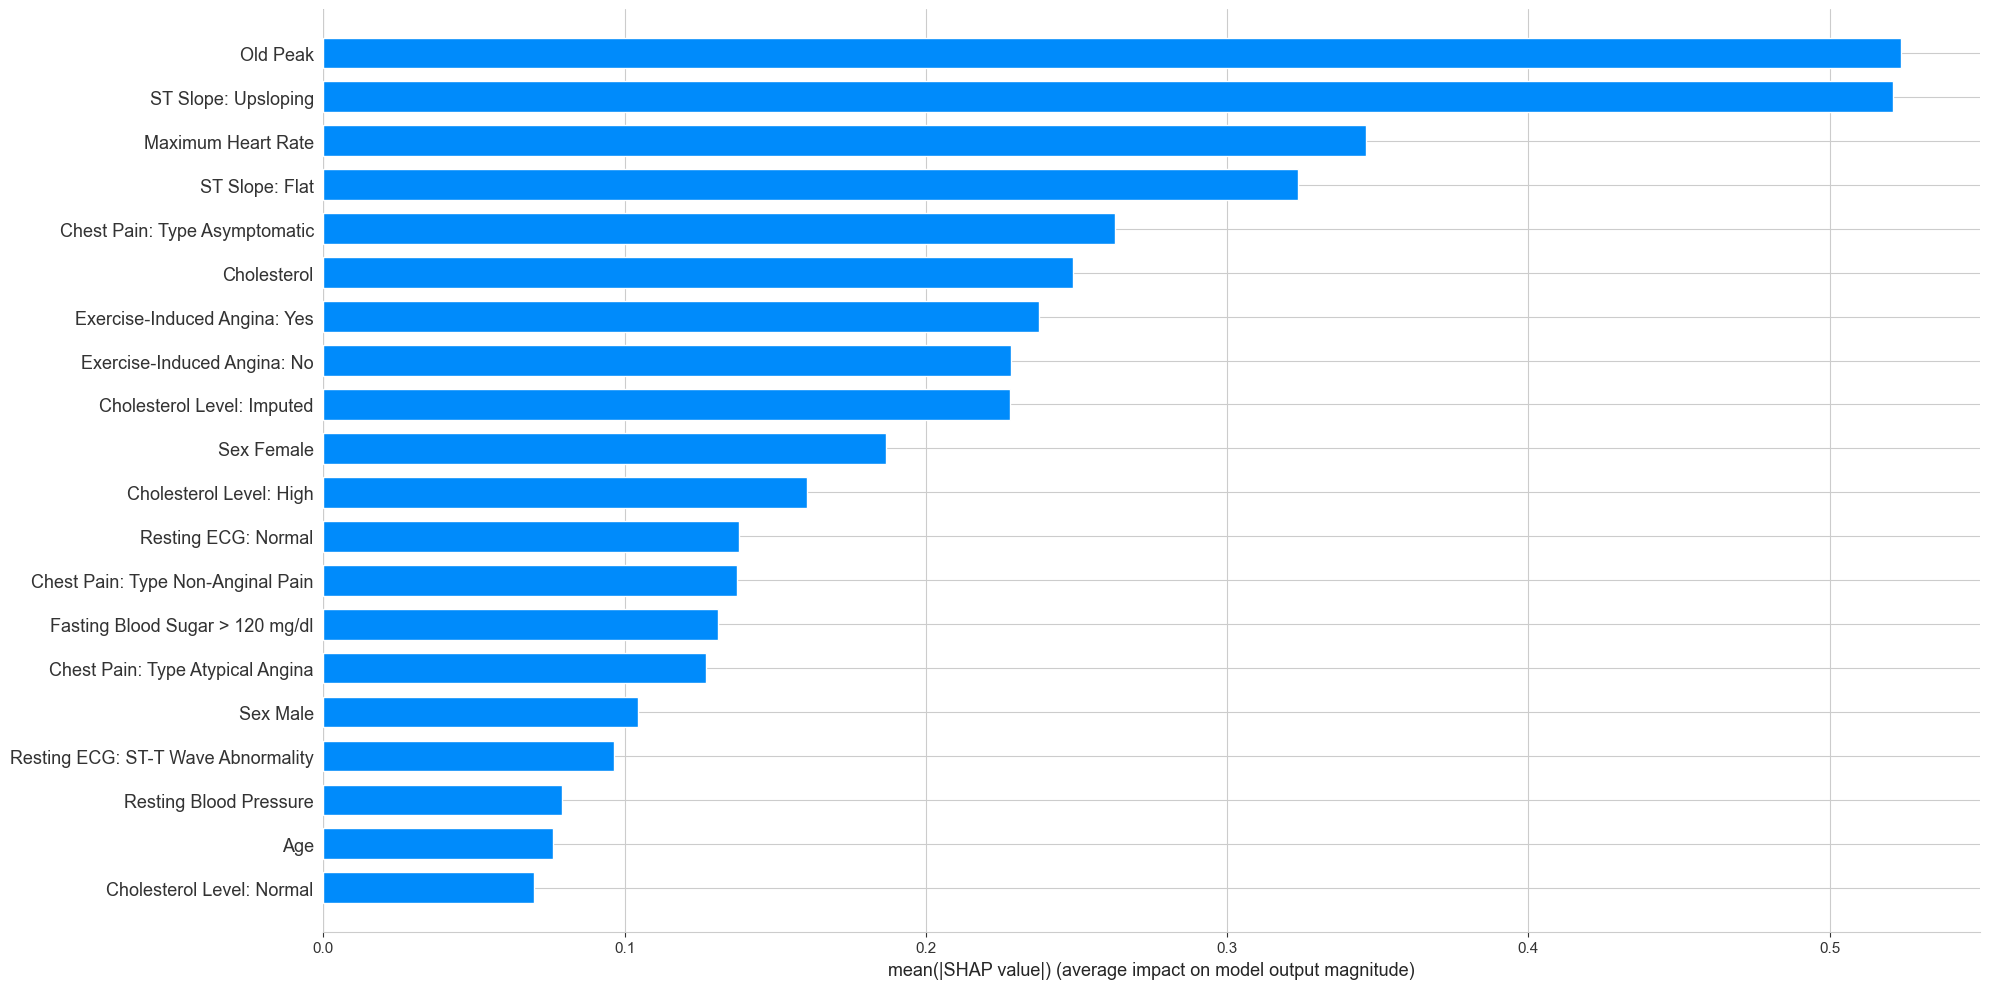

In [82]:
shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="bar",
    plot_size=[20, 10],
)

The features that are marked as important in the plot above seem to be the same ones as in the experiments file of the neural additive model, so it does seem as if we do have consistency for feature importance among the two different predictions.